In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
import h5py
import random
import scipy.io as sio
from data import IronDataset
import torchvision.transforms as tr
from torch.utils.data import DataLoader
from model import UNet, WPU_Net
from weight_map_loss import WeightMapLoss
from PIL import Image

cwd = os.getcwd()

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 通过设置随机种子的办法使得pytorch 实验效果可以复制，即使是使用了随机裁剪
# set random seed to make experiments repeatable
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(2019)

batch_size = 2
DATA_FOLDER = os.path.join(cwd,"../", "datasets", "segmentation", "net_train")
print(DATA_FOLDER)

transform = tr.Compose([
    tr.ToTensor(),
    tr.Normalize(mean = [0.9336267], 
                std = [0.1365774])
])

D:\WPU-Net\segmentation\../datasets\segmentation\net_train


4
torch.Size([1, 256, 256])   torch.Size([1, 256, 256])   [0. 1.]   torch.Size([1, 256, 256])   [  0. 255.]   torch.Size([2, 256, 256])   [ 0.3585759   0.3600821   0.36083758 ... 10.999987   11.
 30.        ]
0.48597565   -5.342796
 last mask  [  0. 255.]
 weight  [ 1.         1.4114902  1.4186946 ... 10.99997   10.999987  11.       ]


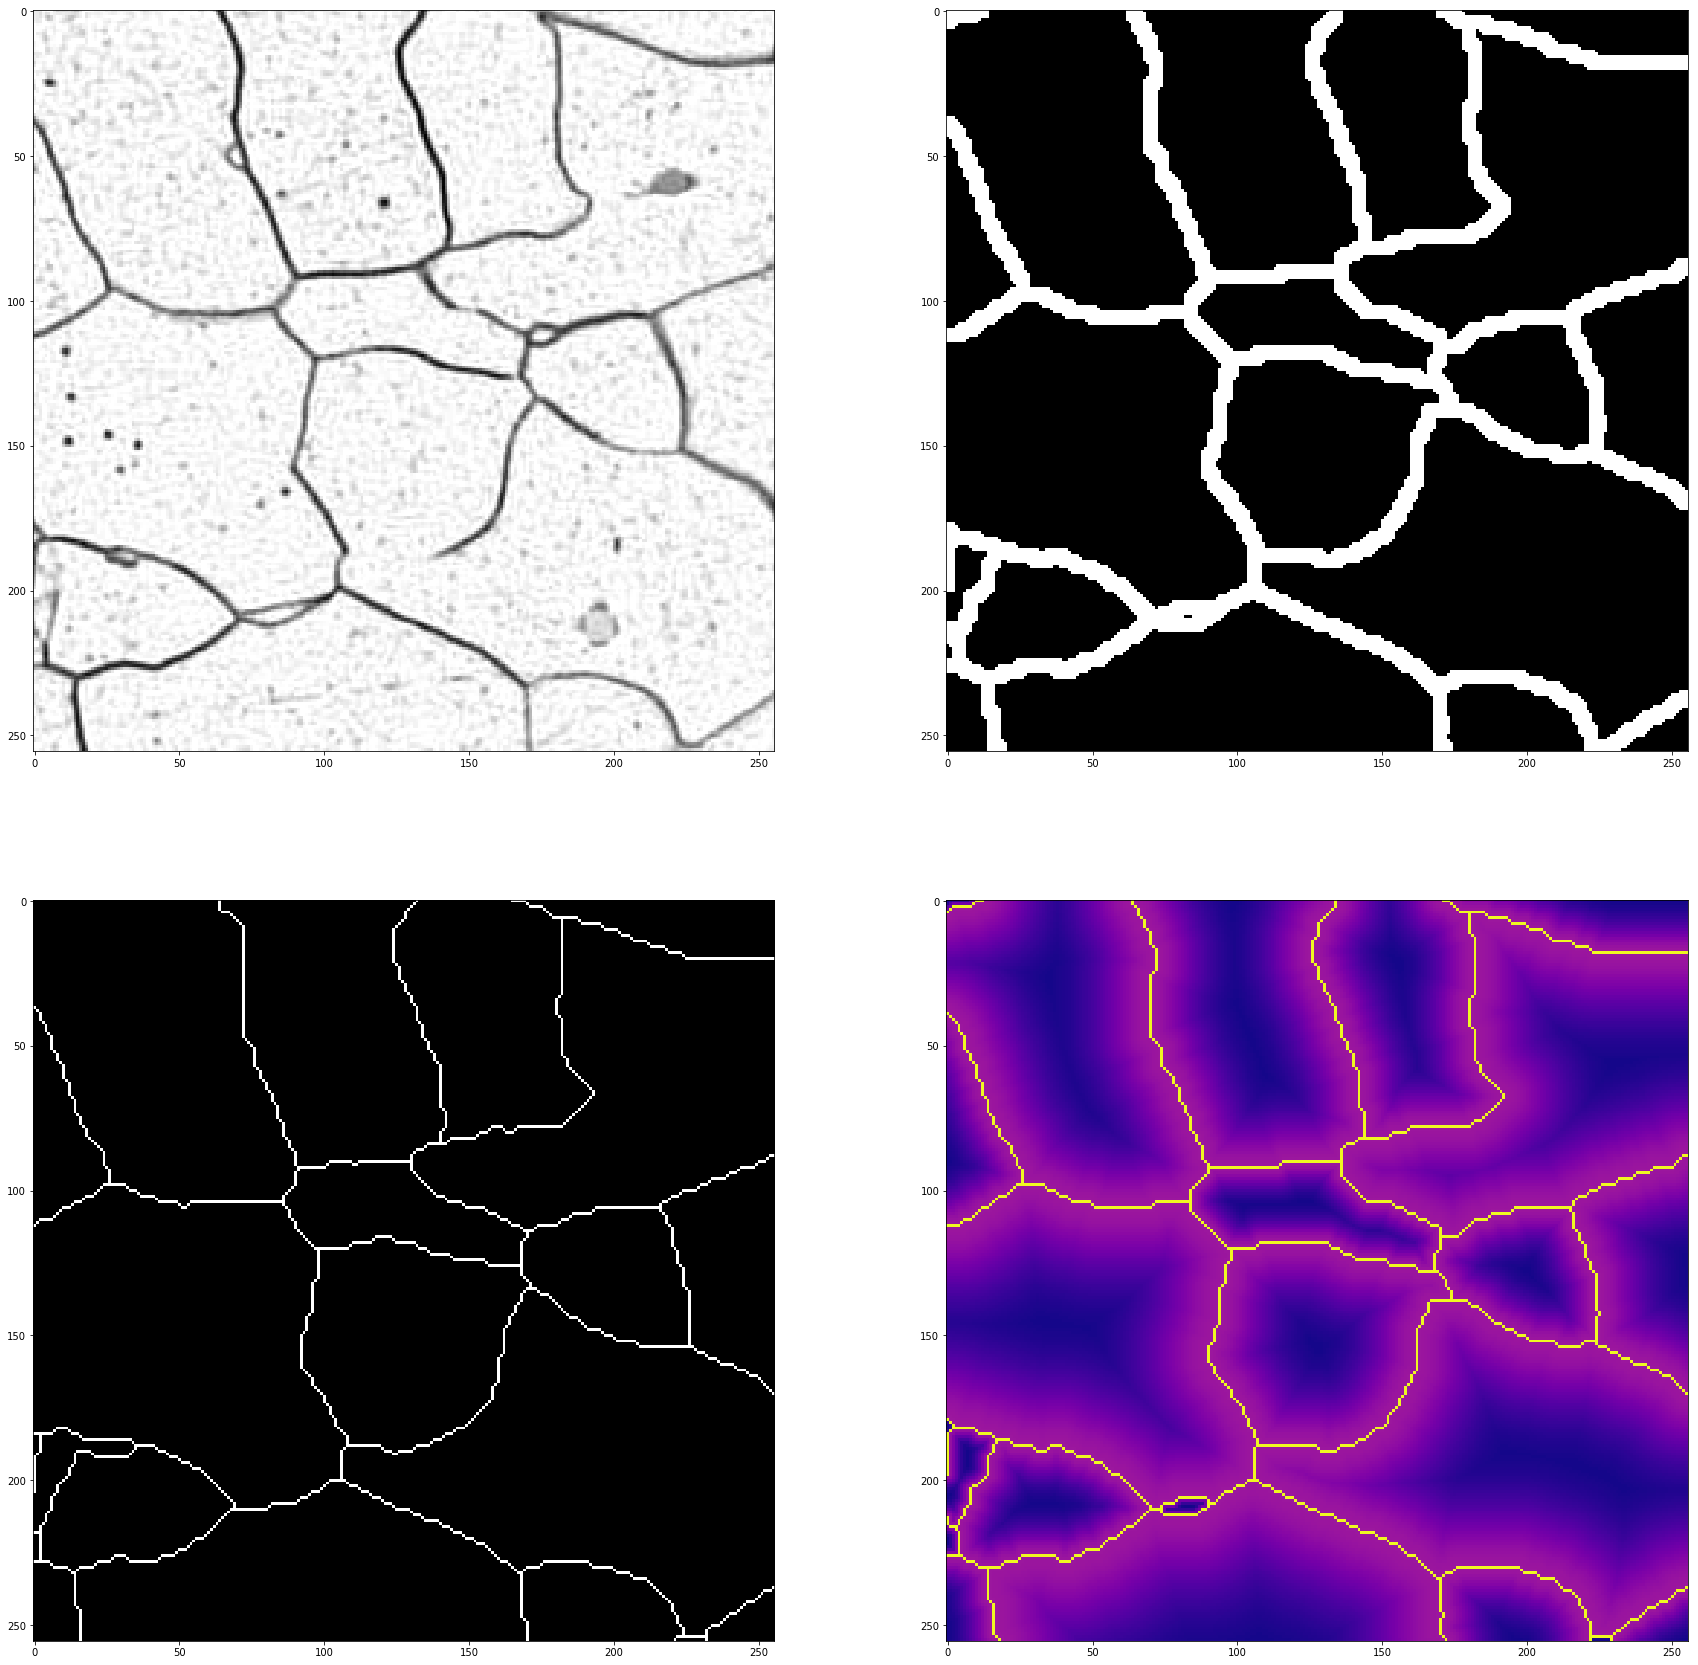

batch_size is  2
64
torch.Size([1, 256, 256])   torch.Size([1, 256, 256])   [0. 1.]   torch.Size([1, 256, 256])   [  0. 255.]   torch.Size([2, 256, 256])   [ 0.3585759   0.36172816  0.36229363 ... 10.999943   11.
 30.        ]
0.48597565   -6.0606246
 last mask  [  0. 255.]
 weight  [ 1.         1.4164237  1.4171854 ... 10.99992   10.999943  11.       ]


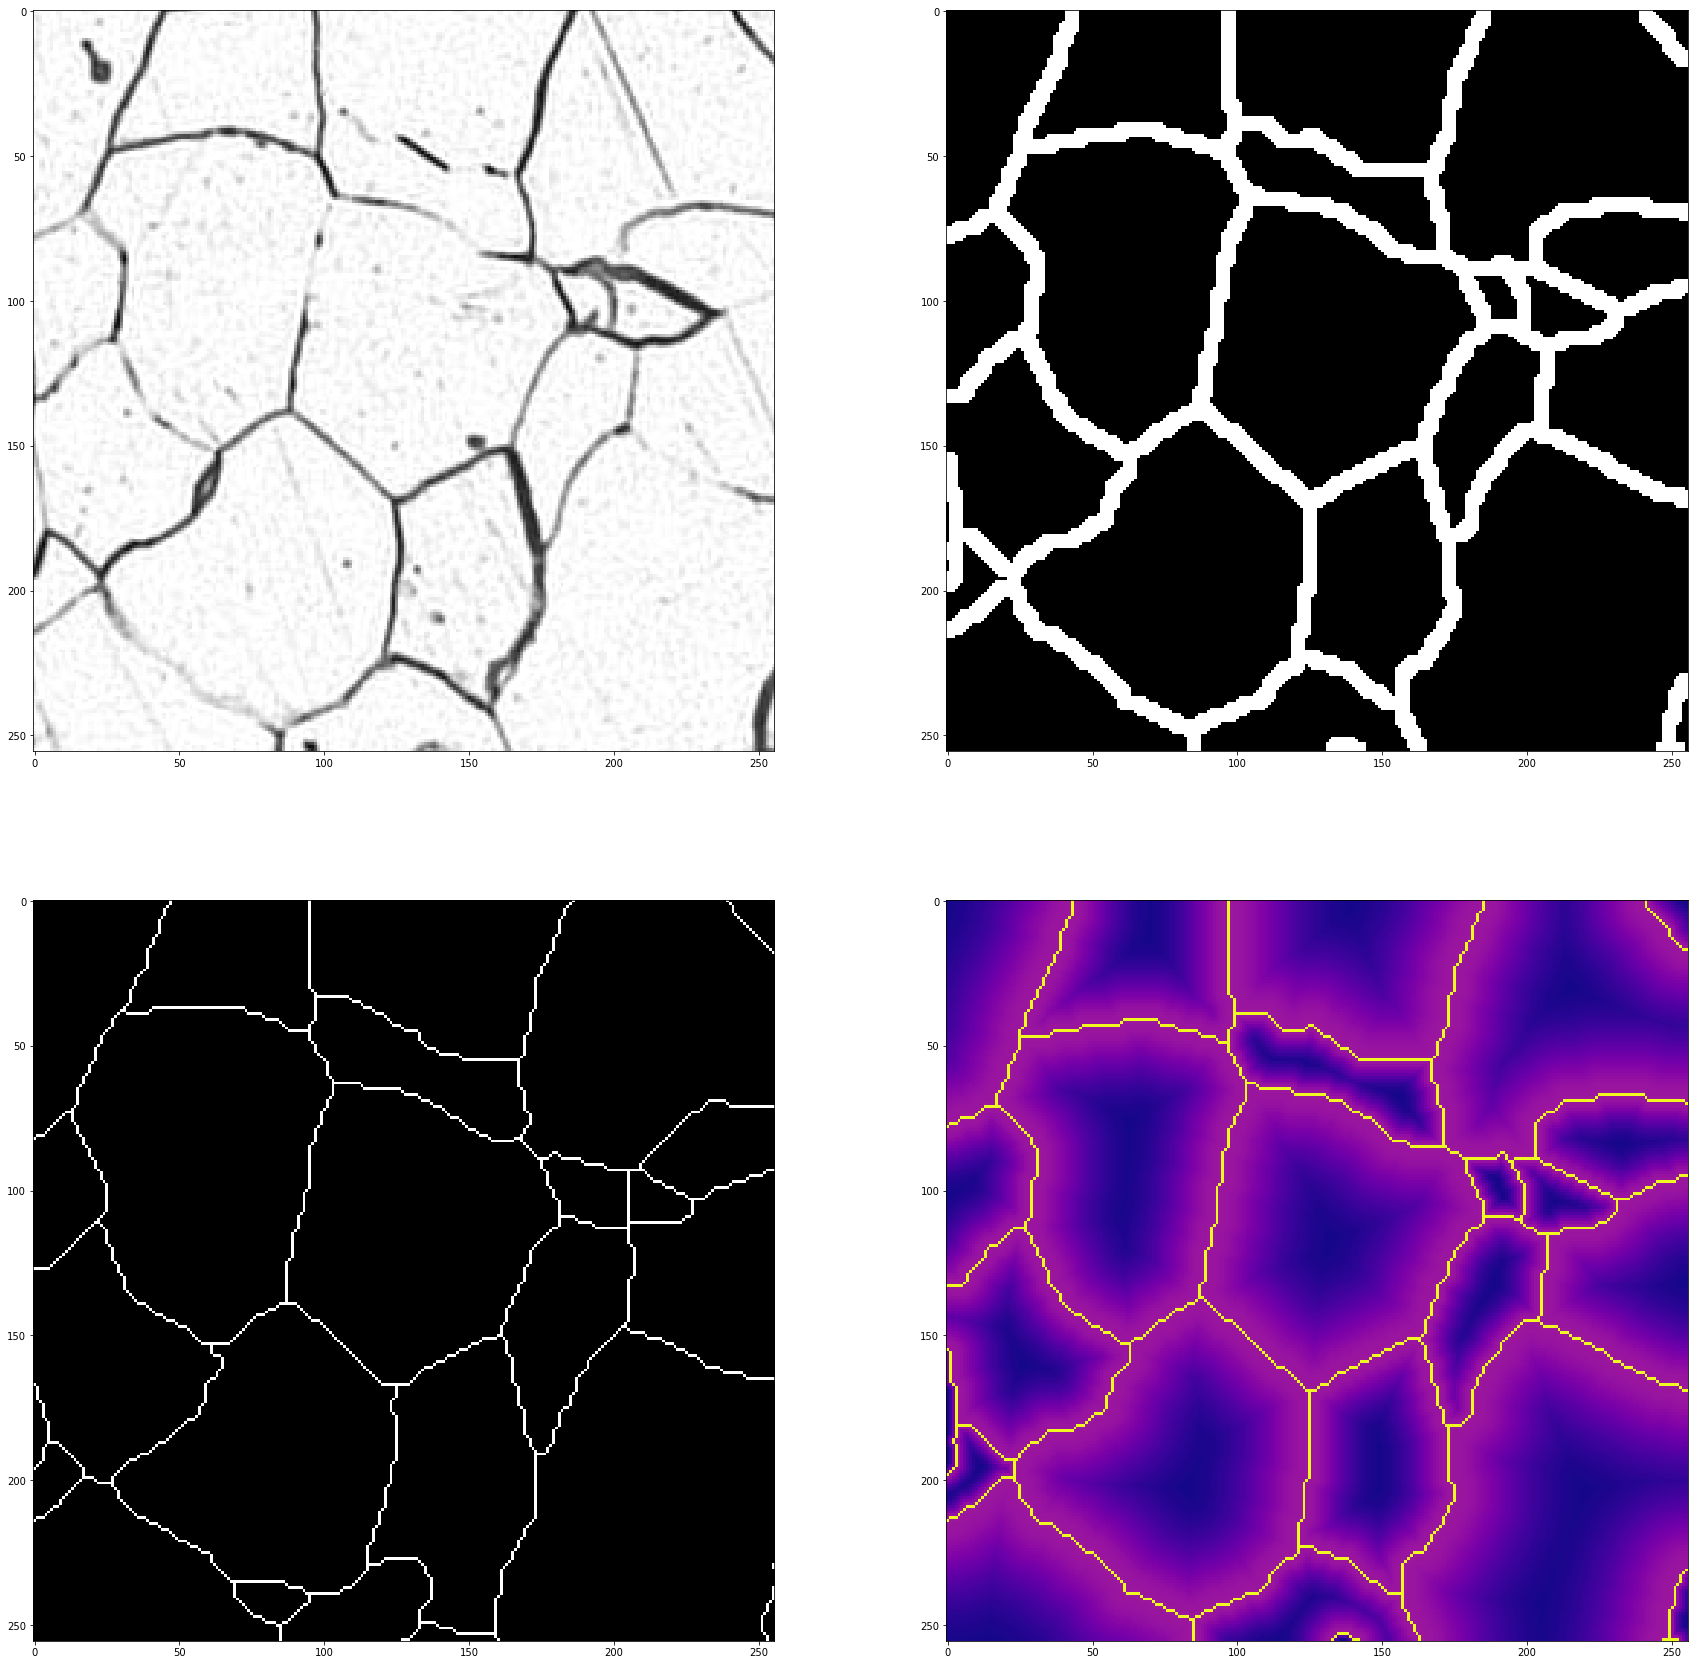

Training Data :  4
Test Data : 64


In [2]:
def check(dataset):   # check the output of dataset
    print(dataset.__len__())
    image, mask, last, weight = dataset.__getitem__(2)
    print(image.size(), " ", mask.size(), ' ', np.unique(mask), " ", last.size(), " ", np.unique(last), " ", weight.size(), " ", np.unique(weight))

    test_image = image.squeeze().numpy() 
    test_mask = mask.squeeze().numpy() 
    last_mask = last.squeeze().numpy() 
    test_weight = weight.squeeze().numpy()
    
    print(np.max(test_image), " ", np.min(test_image)) 
    
    print(" last mask ", np.unique(last_mask))
    print(" weight ", np.unique(weight[0,:,:]))
    
    plt.figure(figsize=(30,30))
    plt.subplot(2,2,1), plt.imshow(test_image, cmap="gray")
    plt.subplot(2,2,2), plt.imshow(test_mask, cmap="gray")
    plt.subplot(2,2,3), plt.imshow(last_mask, cmap="gray")
    plt.subplot(2,2,4), plt.imshow(test_weight[1, :, :], vmin=0, vmax=30, cmap="plasma")
    plt.show()
    
train_dataset = IronDataset(DATA_FOLDER, train=True, transform=transform, crop = True, crop_size=(256, 256), dilate = 5)
check(train_dataset)
print('batch_size is ', batch_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

test_dataset = IronDataset(DATA_FOLDER, train=False, transform=transform, crop = False, dilate = 5)
check(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

print("Training Data : ", len(train_loader.dataset))
print("Test Data :", len(test_loader.dataset))

In [3]:
learning_rate = 1e-4
model = WPU_Net(num_channels=2, num_classes=2, multi_layer = True)
print(model)

# 初始化参数
def weights_init(m):
    classname = m.__class__.__name__ # 得到网络层的名字，如ConvTranspose2d
    if classname.find('Conv2d') != -1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(weights_init)

if torch.cuda.is_available():
    model = nn.DataParallel(model).cuda()

optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9, eps=1e-5) 

# self.weight = torch.Tensor([1, 20])
# if torch.cuda.is_available():
#     self.weight = self.weight.cuda()
# self.criterion = torch.nn.CrossEntropyLoss(weight=self.weight)

# print(weight)

criterion=WeightMapLoss(_dilate_cof=5)
method = 4

multi_layer  True
WPU_Net(
  (down1): Conv3x3(
    (conv1): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (down2): Conv3x3(
    (conv1): Sequential(
      (0): Conv2d(65, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (down3): Conv3x3(
    (conv1): Sequential(
      (0

In [5]:
import torch.nn.functional as F
from skimage import morphology

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by half every 10 epochs until 1e-5"""
    lr = learning_rate * (0.8 ** (epoch // 10))
    if not lr < 1e-6:
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

def train(net, epoch, loss_list, plotimgs):
    net.train()
    adjust_learning_rate(optimizer, epoch)
    iterations=int(len(train_loader.dataset)/batch_size)
    for batch_idx, (image, mask, last, weight) in enumerate(train_loader):
        images=[]
        label = mask.squeeze(1).type(torch.LongTensor)
        
        if torch.cuda.is_available():
            img, label ,last, weight= image.cuda(), label.cuda(), last.cuda(), weight.cuda()
            
        optimizer.zero_grad()
        
        # mask
        last[last == 255] = -6
        last[last == 0] = 1 

        output = net(img, last)
#         loss = criterion_unet(output, label)
        loss = criterion(output, label, weight, method=method)
        loss.backward()
        # 梯度裁剪
        nn.utils.clip_grad_norm_(net.parameters(), 5)
        optimizer.step()

        if (batch_idx+1) % iterations == 0:
            loss_list.append(float(loss.item()))
            
            # Display the output image of the intermediate process
            if plotimgs :
                images.append(image[0].squeeze().numpy())
                images.append(mask[0].squeeze().numpy())
                images.append(last[0].squeeze().cpu().numpy())
                images.append(weight[0].squeeze().cpu().numpy()[1, :, :])
                out = torch.sigmoid(output[0])
                result_npy = out.max(0)[1].data.squeeze().cpu().numpy()
                result_npy = np.array(result_npy).astype('uint8')*255
                images.append(result_npy)
                result_npy_nc = morphology.skeletonize(result_npy / 255) * 255  # 骨架化 Skeletonization
                images.append(result_npy_nc)
                
                # [0] original  [1] mask  [2] result [3] result_fc
                plot_imgs(str(epoch).zfill(3)+'_train',images)

def test(net, test_loss_list):
    net.eval()
    test_loss = 0
    images=[]
    count = 0
    for batch_idx, (image, mask, last, weight) in enumerate(test_loader): 
        count += 1
        if torch.cuda.is_available():
            label = mask.squeeze(1).type(torch.LongTensor)
            img, label, last, weight= image.cuda(), label.cuda(), last.cuda(), weight.cuda()
        
        # mask
        last[last == 255] = -6
        last[last == 0] = 1 

        output = net(img, last)
#         test_loss += float(criterion_unet(output, label).item())
        test_loss += float(criterion(output, label, weight, method=method).item())
        if batch_idx==1:
            images.append(image.squeeze().numpy())
            images.append(mask.squeeze().numpy())
            images.append(last.squeeze().cpu().numpy())
            images.append(weight.squeeze().cpu().numpy()[1, :, :])
            out = torch.sigmoid(output)
            result_npy = out.max(1)[1].data.squeeze().cpu().numpy()
            result_npy = np.array(result_npy).astype('uint8')*255
            images.append(result_npy)
            result_npy_nc = morphology.skeletonize(result_npy / 255) * 255  # 骨架化
            images.append(result_npy_nc)
    
    # Average WCE loss
    test_loss /= count
    test_loss_list.append(test_loss)
    return test_loss, images



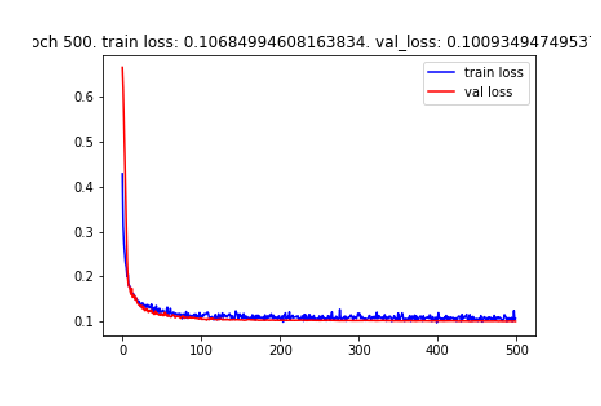

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

def plot_imgs(title, imgs):
 
    plt.figure(figsize=(30,30))
    plt.subplot(231)
    plt.imshow(imgs[0], cmap ='gray')
    plt.axis('off')
    plt.title(title+'_img-label-out-skle')
    plt.subplot(232)
    plt.imshow(imgs[1], cmap ='gray')
    plt.axis('off')
    plt.subplot(233)
    plt.imshow(imgs[2], cmap ='gray')
    plt.axis('off')
    plt.subplot(234)
    plt.imshow(imgs[3])
    plt.axis('off')
    plt.subplot(235)
    plt.imshow(imgs[4], cmap ='gray')
    plt.axis('off')
    plt.subplot(236)
    plt.imshow(imgs[5], cmap ='gray')
    plt.axis('off')
    plt.savefig(checkpoint_path+str(title)+'.png')
    
def plot(epoch, loss_list, test_loss_list):
    clear_output(True)
    plt.figure()
    plt.title('epoch %s. train loss: %s. val_loss: %s' % (epoch, loss_list[-1], test_loss_list[-1]))
    plt.plot(loss_list, color="r", label="train loss")
    plt.plot(test_loss_list, color="b", label="val loss")
    plt.legend(loc="best")
    plt.savefig(checkpoint_path+'test_model_loss_state.png')
    plt.show()
    
loss_list = []
test_loss_list = []
epochs = 500
test_baseline = 10000

# model save address
checkpoint_path='./parameter/WPU_Net_model/'
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path) 

for i in range(1,epochs+1):
    if (i-1) % 10 == 0:
        plotimgs = True
    else:
        plotimgs = False
    train(model, i, loss_list, plotimgs)
    test_loss, imgs = test(model, test_loss_list)
    f=open(checkpoint_path+'loss.txt','a') 
    f.write("epoch %d:loss %f \n"%(i,loss_list[-1]))
    f.write("epoch %d:loss %f test_loss %f\n"%(i,loss_list[-1],test_loss_list[-1]))
    f.close()
    plot(i, loss_list, test_loss_list)
    if (i-1)%10 == 0:
        plot_imgs(str(i).zfill(3)+'_test',imgs)
        torch.save(model.state_dict(), checkpoint_path+str(i)+'_epoch'+'.pth')
    if test_loss < test_baseline:
        test_baseline = test_loss
        torch.save(model.state_dict(), checkpoint_path+"best_model_state.pth")